In [1]:
import seaborn as sns

from sklearn.model_selection import train_test_split

# from the textbook, for printing a process bar.
import pyprind

# basic packages
import pandas as pd
import os
import numpy as np
import re # python regular expressions
import string # for efficient operations with strings
import matplotlib.pyplot as plt
%matplotlib inline

# For creating dictionaries that you can fill in a loop
from collections import defaultdict

# NLTK: A basic, popular NLP package. Find many examples of applications at https://www.nltk.org/book/
# Install guide: https://www.nltk.org/install.html
import nltk
nltk.download('punkt') # you will probably need to do this
nltk.download('wordnet') # and this
nltk.download('stopwords') # aand this

# for vectorization 
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

#Vader Lexicon for sentiment analysis
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# similarity/distance measures
from scipy.spatial import distance
from sklearn.metrics.pairwise import linear_kernel, cosine_similarity

# for classification
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

# Lexicons for sentiment analysis
from vaderSentiment import vaderSentiment
from afinn import Afinn

# to display images in notebook
from IPython.display import Image

[nltk_data] Downloading package punkt to C:\Users\Liv
[nltk_data]     Nøhr\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to C:\Users\Liv
[nltk_data]     Nøhr\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to C:\Users\Liv
[nltk_data]     Nøhr\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [18]:


df_p = pd.read_csv('df_final.csv')
df_c = pd.read_csv('df_comments_final.csv')
df_c = df_c[df_c['Comments'] != 'No Comments']
df_c['Comments'] = df_c['Comments'].dropna()

df_c

,Unnamed: 0,Comments,Quality,Difficulty,Dates,TeacherID,SchoolID,status
0,0,"Professor Acres is incredible--friendly, knowl...",5.0,4.0,2017-05-02,336888,780,top
1,1,He is an amazing professor- I definitely recom...,5.0,3.0,2017-04-28,336888,780,top
2,2,Great!,3.0,3.0,2012-03-23,336888,780,top
3,3,Awesome,5.0,1.0,2011-02-01,336888,780,top
4,4,Al is an absolutely great professor. His semin...,5.0,4.0,2007-10-21,336888,780,top
...,...,...,...,...,...,...,...,...
81712,81712,Difficult to understand and not very helpful. ...,1.5,3.0,2009-12-23,608528,4171,bottom
81713,81713,MUY MAL!! This teacher is unorganized and scat...,1.0,1.0,2005-12-22,608528,4171,bottom
81714,81714,very sweet disposition -- very willing to help...,5.0,1.0,2005-12-20,608528,4171,bottom
81715,81715,"This professor is very helpful, wants her stud...",5.0,1.0,2005-09-06,608528,4171,bottom


In [5]:
print(df_c["Difficulty"].mean())
print(df_c["Quality"].mean())


#Depending on school status

print(df_c.groupby('status', as_index=False)['Difficulty'].mean())
print(df_c.groupby('status', as_index=False)['Quality'].mean())

#Make column with length of comments
df_c['len_col'] = df_c['Comments'].str.len()

print(df_c.groupby('status', as_index=False)['len_col'].mean())

print(df_c.groupby('status').size())

3.0646958011996572
3.6752940718236347
   status  Difficulty
0  bottom    3.058657
1     top    3.085095
   status   Quality
0  bottom  3.649276
1     top  3.763188
   status     len_col
0  bottom  240.208517
1     top  189.889530
status
bottom    61698
top       18095
dtype: int64


In [6]:
#See variance

print(df_c.groupby('status', as_index=False)['Quality'].var())
print(df_c.groupby('status', as_index=False)['Difficulty'].var())


   status   Quality
0  bottom  2.179516
1     top  2.209166
   status  Difficulty
0  bottom    1.553341
1     top    1.526440


<AxesSubplot:xlabel='Quality', ylabel='count'>

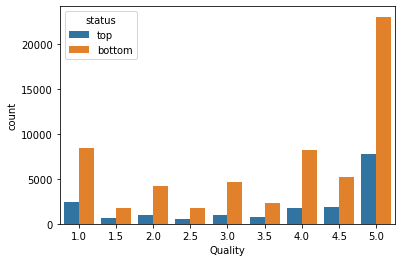

In [7]:
#sns.countplot(data=df_c, x='Difficulty')

sns.countplot(data=df_c, x='Quality', hue = 'status')

<AxesSubplot:xlabel='year', ylabel='Comments'>

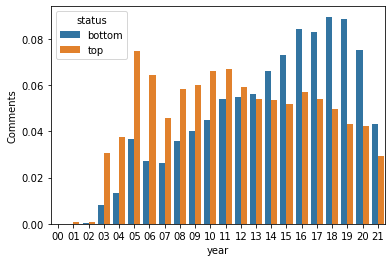

In [86]:
import datetime

df_c['year'] = df_c['Dates'].str[2:4]

statgrouped = df_c.groupby(["status", "year"]).count()

statgrouped =statgrouped.groupby(level=[0]).apply(lambda g: g / g.sum())
statgrouped=statgrouped.reset_index()

statgrouped

sns.barplot(data=statgrouped, x='year', y='Comments', hue = 'status')




In [ ]:
with open('STOPlist.txt') as f:
    stoppelop = f.read().splitlines()
stoppelop


In [93]:
def preprocess(text):
    low_text= text.lower()
    low_text = low_text.translate(str.maketrans('', '', string.punctuation))
    tokens = nltk.word_tokenize(low_text)
    porter = nltk.WordNetLemmatizer()
    lemmatizer=[porter.lemmatize(t) for t in tokens]
    stop_words_list = stoppelop
    sent_sw_removed = [i for i in lemmatizer if i not in stop_words_list]
    lemmas=[i for i in sent_sw_removed if i!='br']
    return lemmas # return a list of stems/lemmas

In [20]:
df_c=df_c[df_c['Comments']!='No Comments'].dropna()

df_c['Clean_comment']=df_c.apply(lambda row: preprocess(row.Comments), axis = 1)

In [30]:
X = df_c['Comments']

y = df_c['Quality']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=161193)


# CountVectorizer (from sklearn.feature_extraction.text) has a build-in tokenizer and lowercases by default. It also has an option to remove stopwords (look at the documentation).
vectorizer = CountVectorizer()

# You can override the default tokenization with your own defined function, like so:
vectorizer = CountVectorizer(tokenizer=preprocess)

# you can also restrict the number of features to the top N most frequent features:
#vectorizer = CountVectorizer(max_features=N)

# fit and transform train set
X_train_bow = vectorizer.fit_transform(X_train)

# Only tranform test set: never fit your vectorizer on the test set (it is cheating). Out-of-Vocabulary words are handled automatically be sklearn's vectorizer.
X_test_bow = vectorizer.transform(X_test)

In [31]:
print(X_train_bow.shape)
print(len(vectorizer.vocabulary_))
X_train_bow[0]

(57654, 32583)
32583


<1x32583 sparse matrix of type '<class 'numpy.int64'>'
	with 16 stored elements in Compressed Sparse Row format>

In [36]:
X_train_bow[0].toarray() # the vector is very sparse..
print(X_train_bow[0]) # here we take a look at the non-zero elements. 
#The first element is the word with ID 25459, which appears two times in the text.
print(vectorizer.get_feature_names()[13844]) # this is one way to get the word with the ID 25459

  (0, 25227)	1
  (0, 13553)	1
  (0, 24086)	1
  (0, 28582)	1
  (0, 5929)	2
  (0, 28420)	3
  (0, 31980)	1
  (0, 16024)	1
  (0, 31154)	2
  (0, 3915)	1
  (0, 20101)	1
  (0, 13844)	1
  (0, 22285)	1
  (0, 28459)	1
  (0, 22749)	1
  (0, 12759)	1
helpful


In [48]:
##TF_IDF

tfidf = TfidfVectorizer()
X_train_tfidf = tfidf.fit_transform(X_train)

In [62]:
cosine_similarities = cosine_similarity(X_train_tfidf[100], X_train_tfidf).flatten()

indices = cosine_similarities.argsort()[::-1] # in descending order 
print("most similar:",indices[:10])
print("least similar", indices[-9:])

most similar: [  100 55483 57563 37648 11135 22220  4948  3379 23069 35121]
least similar [ 2901 15920 34930 15907 34976 44921 53515 34989 52065]


In [66]:
print(X_train[100])
print()
print("most similar: ", X_train[55483  ])
print()
print("least similar: ", X_train[2901  ])

Professor Brinton was an amazing professor and really helped me through the class. He was readily available for questions and puts a lot of time into his courses. I would highly recommend him if you have the opportunity to take one of his classes.

most similar:  Marcus was very helpful when i was confused.  Great teacher to have.

least similar:  Great. Very well-read and informed. Brings a global perspective to his class which most Americans do not.


In [74]:
from gensim.models import Word2Vec


X = df_c['Clean_comment']

y = df_c['Quality']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=161193)


# using the train_sents from earlier (the lowercased and tokenized sentences)
model = Word2Vec(X_train, vector_size=50)#the default learning algorithm is CBOW. To use skip-gram use the paramter sg=1.

# You can load pretrained embeddings downloaded from: https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit?usp=sharing 
# BUT this takes up a lot of space (the file is over 1 GB) and a lot of RAM when you try to use it.
# If you want to try it, write this:
#model = gensim.models.KeyedVectors.load_word2vec_format(directory_path+'GoogleNews-vectors-negative300.bin', binary=True)


In [77]:
model.wv['professor']

array([-0.3427301 ,  1.6213628 ,  0.18186499, -0.6462621 ,  0.19362907,
       -1.1867796 ,  2.288043  , -0.22551453,  2.7086349 ,  0.43891525,
        2.292423  , -0.9978531 ,  1.0667039 ,  0.7378389 ,  0.45770636,
        1.1756386 ,  0.5812719 ,  0.38641572, -2.8912237 , -1.594051  ,
        1.8976976 ,  0.00520311,  1.3018486 ,  0.22148238, -0.9200242 ,
       -0.12997903,  1.2154835 ,  1.8347392 ,  0.01004102, -0.37225938,
       -1.2753783 , -1.0325412 ,  1.5503664 , -0.51728296,  0.36603075,
        0.7540513 ,  0.63373584, -0.46928576, -0.09215516,  2.1362817 ,
        0.10410433, -0.05551953,  0.3986686 , -1.0420195 ,  2.4545798 ,
       -0.7012055 , -0.49838266, -0.7577969 ,  0.7570233 ,  0.20809633],
      dtype=float32)

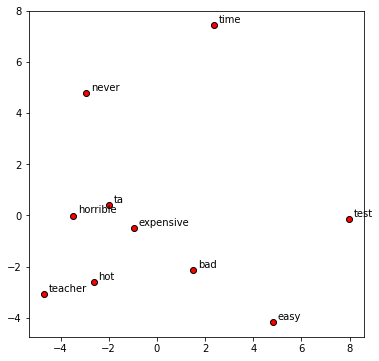

In [82]:
# Reducing the 50-dimensional vectors to 2 dimensions in order to visualise selected words.
from sklearn.decomposition import PCA

words = ["test","easy", "teacher", "ta", "bad", "horrible", "time", "expensive", "hot", "never"]

X = [model.wv['test'], model.wv['easy'], 
     model.wv['teacher'], model.wv['ta'], 
     model.wv['bad'], model.wv['horrible'], 
     model.wv['time'], model.wv['expensive'],
     model.wv['hot'], model.wv['never']]

pca = PCA(n_components=2)
X_r = pca.fit(X).transform(X)

plt.figure(figsize=(6,6))
plt.scatter(X_r[:,0], X_r[:,1], edgecolors='k', c='r')
for word, (x,y) in zip(words, X_r):
    plt.text(x+0.2, y+0.1, word)

In [84]:
###SE PÅ SENERE

embedded_text = np.array([np.mean([model.wv[w] if w in model.wv.key_to_index.keys() else np.zeros(50) for w in words], axis=0) for words in X_train])


# Using the averaged word2vec document embeddings to find similar documents:
cosine_similarities = cosine_similarity(embedded_text[0].reshape(1,50), embedded_text[:]).flatten()
indices = cosine_similarities.argsort()[::-1] # in descending order 
print("most similar:",indices[:10])
print("least similar", indices[-9:])
print(X_train[0])
print()
print("most similar: ", X_train[5052])
print()
print("least similar: ", X_train[22007])

C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
<ipython-input-84-a7855ecdb29a>:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  embedded_text = np.array([np.mean([model.wv[w] if w in model.wv.key_to_index.keys() else np.zeros(50) for w in words], axis=0) for words in X_train])


ValueError: setting an array element with a sequence.

In [100]:
y = np.where(df_c['Quality']>=3.5, 'good', 'bad')

X = df_c['Comments']

np.where(df_c['Quality']>=3.5, 'good', 'bad')
   

print(len(y))
print(len(X))
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=161193)

76872
76872


In [102]:
# Get feature vectors
tfidf = TfidfVectorizer()
# use your own preprocessing function in the vectorizer when you've finished that exercise:
#tfidf = TfidfVectorizer(tokenizer=preprocess)
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

# labels
y_train = y_train
y_test = y_test

# classifier
lr = LogisticRegression(random_state=0)

#training
lr.fit(X_train_tfidf,y_train)

#testing
train_preds = lr.predict(X_train_tfidf)
test_preds = lr.predict(X_test_tfidf)
print("training accuracy:", np.mean([(train_preds==y_train)]))
print("testing accuracy:", np.mean([(test_preds==y_test)]))

training accuracy: 0.8362646130363895
testing accuracy: 0.8092933707982101


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [103]:
features = ['_'.join(s.split()) for s in tfidf.get_feature_names()]
coefficients = lr.coef_
coefs_df = pd.DataFrame.from_records(coefficients, columns=features)
coefs_df

,00,000,000001g,0006,001,0010,002,004,005,0072558318,...,ás,útil,ōlelo,ʻana,ʻike,ʻo,ʻoe,ʻoluʻolu,ʻoʻoleʻa,爸爸
0,0.048164,-0.137459,-0.117054,-0.064267,-0.220373,0.084337,0.020846,0.019865,0.081524,-0.111459,...,0.187838,0.072255,0.020433,0.045995,0.045995,0.091989,0.045995,0.045995,0.045995,0.140488


In [104]:
print(coefs_df.T.sort_values(by=[0], ascending=False).head(20))
print()
print(coefs_df.T.sort_values(by=[0], ascending=True).head(20))

                     0
great         4.665930
amazing       4.644933
best          4.631600
excellent     4.494046
awesome       3.950368
wonderful     3.724243
helpful       3.477301
loved         3.052912
hilarious     2.875124
fun           2.809272
fantastic     2.733415
highly        2.700198
interesting   2.686381
cool          2.684344
explains      2.669693
cares         2.561864
rocks         2.544533
favorite      2.536366
easy          2.446267
enthusiastic  2.414573

                    0
worst       -6.675677
not         -5.295324
avoid       -4.584834
unclear     -4.035717
horrible    -3.625365
rude        -3.549601
useless     -3.503210
luck        -3.413324
confusing   -3.302065
terrible    -3.284915
poor        -3.196714
nothing     -3.061069
awful       -2.933359
unorganized -2.867737
unhelpful   -2.847724
doesn       -2.843693
reads       -2.640829
yourself    -2.564195
thinks      -2.547505
vague       -2.538503


## De faktisk modeller

In [95]:
top = df_c[df_c['status']=='top']
bottom = df_c[df_c['status']=='bottom']




In [99]:
#top universities
y_t = np.where(top['Quality']>=3.5, 'good', 'bad')

X_t = top['Comments']

Xt_train, Xt_test, yt_train, yt_test = train_test_split(X_t, y_t, random_state=161193)

#bottom universities
y_b = np.where(bottom['Quality']>=3.5, 'good', 'bad')

X_b = bottom['Comments']

Xb_train, Xb_test, yb_train, yb_test = train_test_split(X_b, y_b, random_state=161193)

In [100]:
# Get feature vectors
tfidf = TfidfVectorizer()
# use your own preprocessing function in the vectorizer when you've finished that exercise:
#tfidf = TfidfVectorizer(tokenizer=preprocess)
Xt_train_tfidf = tfidf.fit_transform(Xt_train)
Xt_test_tfidf = tfidf.transform(Xt_test)

# labels
yt_train = yt_train
yt_test = yt_test

# classifier
lr = LogisticRegression(random_state=0)

#training
lr.fit(Xt_train_tfidf,yt_train)

#testing
ttrain_preds = lr.predict(Xt_train_tfidf)
ttest_preds = lr.predict(Xt_test_tfidf)
print("training accuracy:", np.mean([(ttrain_preds==yt_train)]))
print("testing accuracy:", np.mean([(ttest_preds==yt_test)]))

print(coefs_df.T.sort_values(by=[0], ascending=False).head(20))
print()
print(coefs_df.T.sort_values(by=[0], ascending=True).head(20))

ValueError: np.nan is an invalid document, expected byte or unicode string.

In [98]:
features = ['_'.join(s.split()) for s in tfidf.get_feature_names()]
coefficients = lr.coef_
coefs_df = pd.DataFrame.from_records(coefficients, columns=features)
coefs_df

NotFittedError: Vocabulary not fitted or provided

In [119]:
print(coefs_df.T.sort_values(by=[0], ascending=False).head(20))
print()
print(coefs_df.T.sort_values(by=[0], ascending=True).head(20))

                  0
best       4.550059
amazing    4.030124
great      3.944210
excellent  3.415934
awesome    3.102986
wonderful  2.721556
loved      2.646081
always     2.541157
fantastic  2.474019
love       2.444734
brilliant  2.424629
helpful    2.406449
explains   2.336687
highly     2.276719
willing    2.181848
cares      2.173476
cool       2.133345
sure       1.929296
good       1.927644
clear      1.898594

                     0
worst        -6.463011
not          -5.909493
terrible     -3.902084
horrible     -3.753817
unclear      -3.414217
avoid        -3.110569
no           -2.929982
rude         -2.792904
useless      -2.704012
doesn        -2.635714
thinks       -2.546257
poor         -2.484423
unhelpful    -2.437398
confusing    -2.309770
himself      -2.258127
luck         -2.213404
awful        -2.149665
don          -2.147540
disorganized -2.131567
seems        -2.030893


In [120]:
# Get feature vectors
tfidf = TfidfVectorizer()
# use your own preprocessing function in the vectorizer when you've finished that exercise:
#tfidf = TfidfVectorizer(tokenizer=preprocess)
Xb_train_tfidf = tfidf.fit_transform(Xb_train)
Xb_test_tfidf = tfidf.transform(Xb_test)

# labels
yb_train = yb_train
yb_test = yb_test

# classifier
lr = LogisticRegression(random_state=0)

#training
lr.fit(Xb_train_tfidf,yb_train)

#testing
train_preds = lr.predict(Xb_train_tfidf)
test_preds = lr.predict(Xb_test_tfidf)
print("training accuracy:", np.mean([(train_preds==yb_train)]))
print("testing accuracy:", np.mean([(test_preds==yb_test)]))


training accuracy: 0.8309973045822102
testing accuracy: 0.7981805929919138


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [121]:
features = ['_'.join(s.split()) for s in tfidf.get_feature_names()]
coefficients = lr.coef_
coefs_df = pd.DataFrame.from_records(coefficients, columns=features)
coefs_df

,00,000,000001g,0006,001,00am,00pm,01,011,012,...,zzzzzzzzzzzzzzzzzzzzzz,álvarez,ás,ōlelo,ʻana,ʻike,ʻo,ʻoe,ʻoluʻolu,ʻoʻoleʻa
0,-0.153968,-0.652141,-0.117905,-0.068689,0.041939,-0.098886,0.119629,-0.273118,0.077714,0.077714,...,-0.311484,0.175997,0.186505,0.020482,0.043434,0.043434,0.086868,0.043434,0.043434,0.043434


In [122]:
print(coefs_df.T.sort_values(by=[0], ascending=False).head(20))
print()
print(coefs_df.T.sort_values(by=[0], ascending=True).head(20))

                    0
great        5.166606
best         4.433569
awesome      4.165015
amazing      3.978236
excellent    3.808891
helpful      3.583302
fun          3.354404
wonderful    3.218319
interesting  2.869070
hilarious    2.845134
easy         2.829384
loved        2.741220
cool         2.438599
you          2.332321
highly       2.320102
cares        2.227371
love         2.207271
enjoyable    2.188529
attention    2.125369
favorite     2.070249

                    0
worst       -5.966652
not         -5.182568
avoid       -4.523254
unclear     -4.076124
rude        -3.783279
horrible    -3.416215
luck        -3.343650
unorganized -3.159193
reads       -3.144532
useless     -3.055804
nothing     -3.039199
confusing   -3.018885
terrible    -2.733022
doesn       -2.620068
awful       -2.575519
unhelpful   -2.438693
yourself    -2.377456
no          -2.351225
sucks       -2.273980
never       -2.245244


## TOP OR BOTTOM???

In [107]:
df_c = df_c.dropna(axis=0, how='any', thresh=None, subset=None, inplace=False)

#bottom universities
y= df_c['status']

X = df_c['Comments']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=161193)

In [114]:
# use your own preprocessing function in the vectorizer when you've finished that exercise:
tfidf = TfidfVectorizer(tokenizer=preprocess)
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)


In [115]:
# labels
y_train = y_train
y_test = y_test

# classifier
lr = LogisticRegression(random_state=0)

#training
lr.fit(X_train_tfidf,y_train)

#testing
train_preds = lr.predict(X_train_tfidf)
test_preds = lr.predict(X_test_tfidf)
print("training accuracy:", np.mean([(train_preds==y_train)]))
print("testing accuracy:", np.mean([(test_preds==y_test)]))

training accuracy: 0.8313733652478579
testing accuracy: 0.8029451555833074


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [116]:
features = ['_'.join(s.split()) for s in tfidf.get_feature_names()]
coefficients = lr.coef_
coefs_df = pd.DataFrame.from_records(coefficients, columns=features)
coefs_df

,0,0000001g,0006,001,0010,004,01,010,02,025,...,ʻoʻoleʻa,–,–intext,–keep,‘,’,“,”,爸爸,��
0,-0.531075,-0.035495,-0.035358,-0.290047,0.189124,0.21841,0.173312,0.077042,-0.53569,-0.155601,...,-0.066385,0.036056,-0.01221,-0.01221,-0.138332,-1.044916,-0.077821,-0.137498,0.321493,-0.469866


In [117]:
print(coefs_df.T.sort_values(by=[0], ascending=False).head(40))
print()
print(coefs_df.T.sort_values(by=[0], ascending=True).head(40))

                     0
cal           8.335027
calu          5.395778
jhu           4.648602
mit           4.480599
d2l           4.188520
lecturer      4.044410
orgo          3.493590
bonus         3.436890
brilliant     2.853486
china         2.752921
backtests     2.536598
quarter       2.524976
neuroscience  2.267510
psets         2.129070
engaging      2.046909
pwr           1.956871
linear        1.910469
prof          1.890996
uchicago      1.851459
genius        1.845722
incredible    1.815084
mathematical  1.786480
leading       1.760825
generally     1.751442
rewarding     1.730306
nobel         1.725902
cussw         1.720458
eloquent      1.691061
algorithm     1.663849
excitement    1.653088
introduction  1.647592
intellectual  1.637659
persian       1.634798
doc           1.608832
incredibly    1.597328
analytical    1.596375
quantum       1.592416
ssa           1.589010
team          1.573766
committed     1.536336

                    0
csu         -6.383536
wsu         